In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
link ='https://drive.google.com/file/d/1zH9nR-g8BRiu2BTyGPIoqWo2s0mK21fN/view?usp=sharing'
 
import pandas as pd
 
# to get the id part of the file
id = link.split("/")[-2]

 
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('stock_prices_mod.csv') 
 
df = pd.read_csv('stock_prices_mod.csv')


In [4]:
dates = np.array(df['Date'])
open = np.array(df['Open'])
close= np.array(df['Close'])
high= np.array(df['High'])
low= np.array(df['Low'])
lookbackperiod=n=9



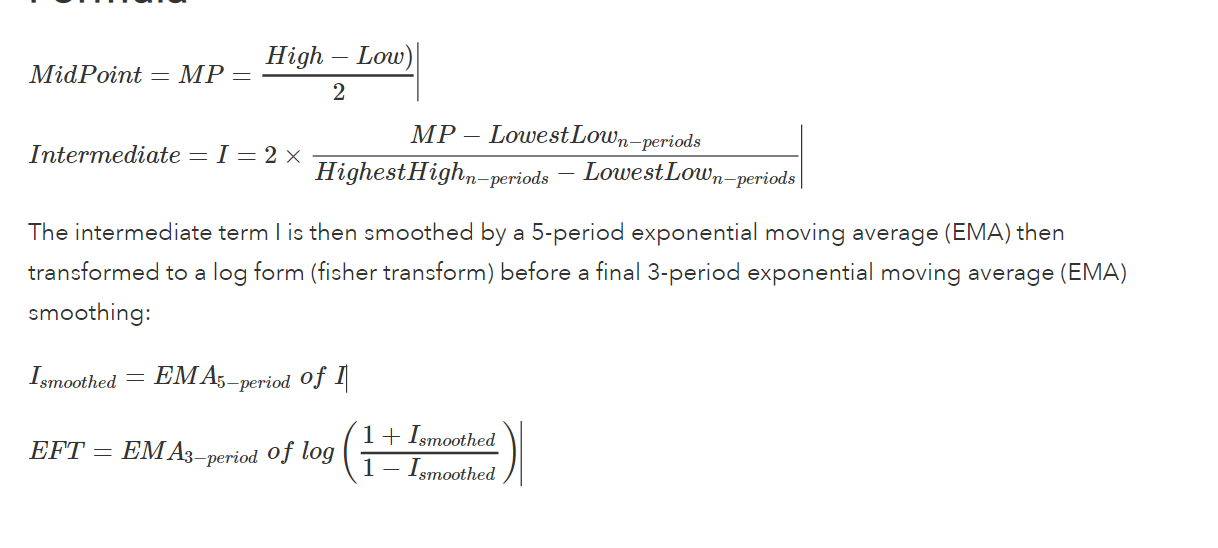

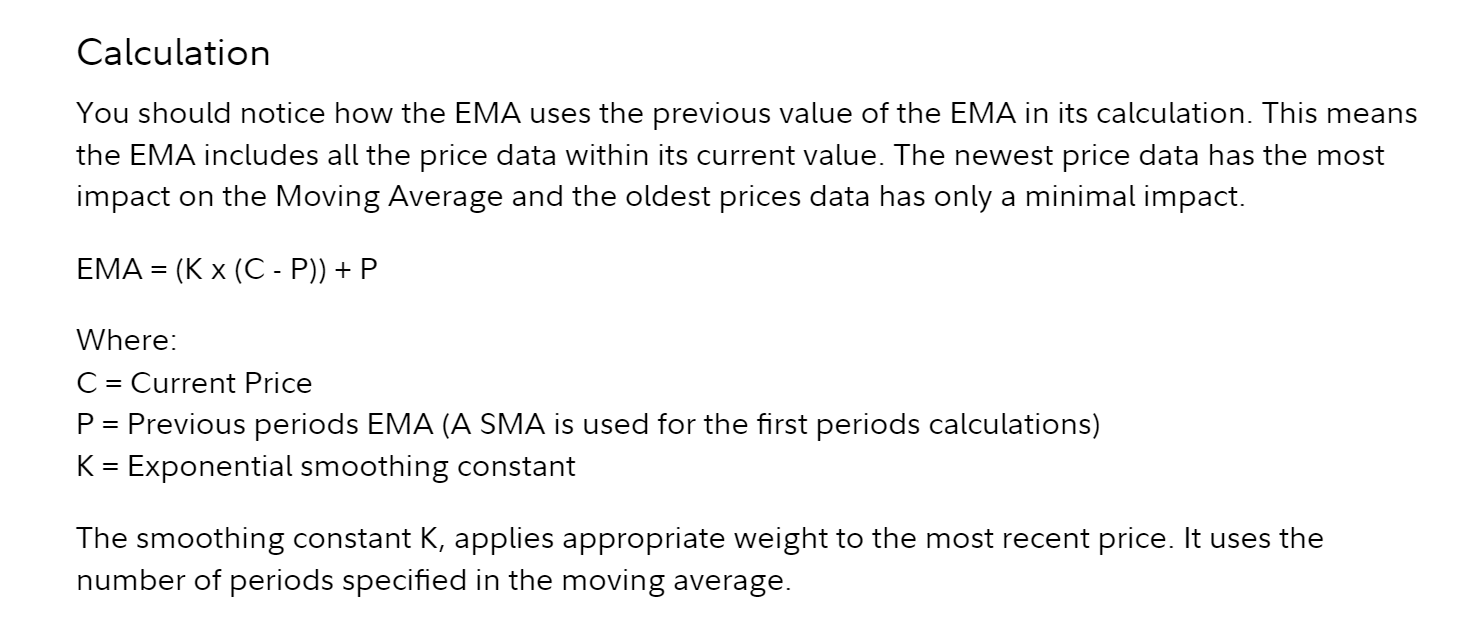

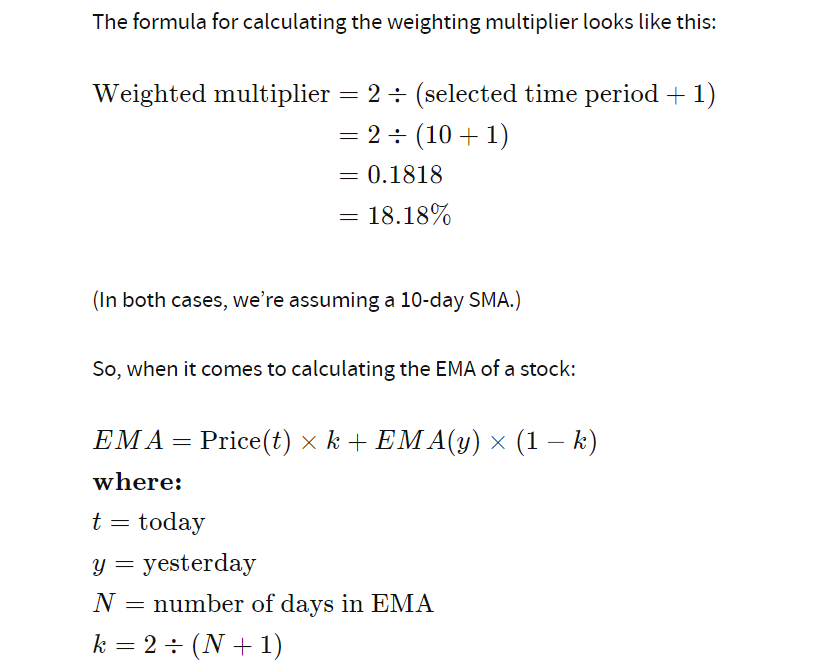

In [5]:
def weightedmovingaverage(Data, period):
    weighted=np.empty(253)
    matrix = np.empty(14)
    total = np.arange(1, period + 1, 1)
    for i in range(253):
      if(i - period + 1>=0):
        matrix= [Data[j] for j in range(i - period + 1,i+1)]
        matrix = np.multiply(total,matrix)
        wma = (matrix.sum()) / (total.sum()) # WMA
        weighted[i] =  wma
      else:
        sum=0
        for k in range(i+1):
          sum+= (k+1)*(Data[k])
        wma1 = sum/((i+1)*(i+2)/2)
        weighted[i] = wma1
    return weighted

def ema(Data, period):
    weighted=np.empty(253)
    k=2/(period +1)
    for i in range(253): 
      if(i>(period-1)):
        weighted[i] = Data[i]*k + weighted[i-1]*(1-k)
      else:
        sum=0
        for m in range(i+1):
          sum+=Data[m]
        weighted[i] = sum/(i+1)
    return weighted

    
sizeArray = 253
hl = (high + low)/2  #calculating the "mid value"
n=9
maxHln = np.zeros(253)
minHln = np.zeros(253)
minHln[0]=low[0]
maxHln[0]=high[0]
for x in range(1,253):
  if(x>n-1):
    maxHln[x] = max(high[x-n:x])
    minHln[x] = min(low[x-n:x])
  elif(x<n):
    maxHln[x] = max(high[0:x], default=0)  
    minHln[x] = min(low[0:x], default=0)  
valTn=np.empty(253)
for x in range(253):
  if maxHln[x]-minHln[x] != 0:
    valTn[x] = 2*((hl[x]-minHln[x])/(maxHln[x]-minHln[x])-0.5)  #using the stochastic formula though its a little modified and the source of the same has been provded in the readme file.
  else :
    valTn[x]=2*((hl[x]-minHln[x])/(1)-0.5)   #in case the numerator is zero i replace it with 0.01 which is of the order of the other non zero values for the expression in denominator

for i in range(253):
  if valTn[i] > 0.99:
   valTn[i] = 0.999
  elif valTn[i] < -0.99:
    valTn[i] = -0.999


valTnsmthd=np.empty(253)
valTnsmthd=ema(valTn,5)



fisher=np.empty(253)
for x in range(253):
  fisher[x] = 0.5*np.log((1.0+valTnsmthd[x])/(1.0-valTnsmthd[x]))

realfisher = ema(fisher,3)
trigger=weightedmovingaverage(realfisher,5)


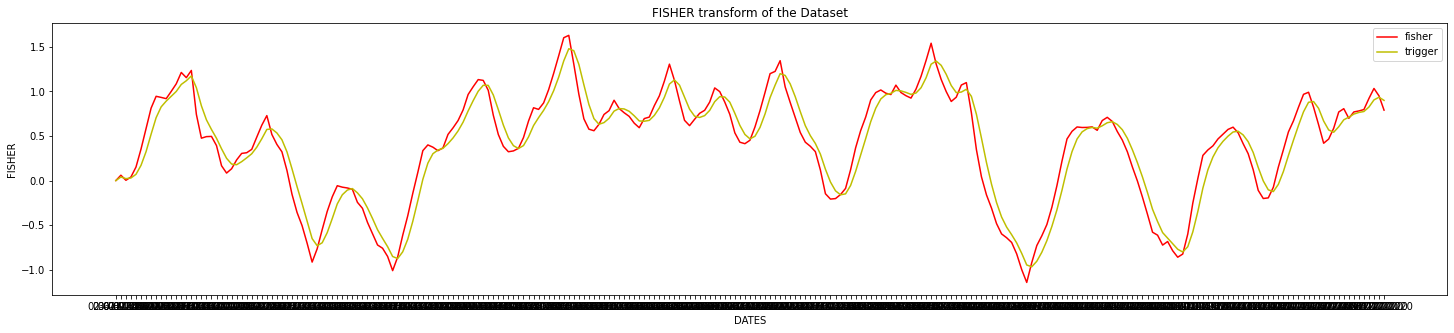

In [6]:
plt.rcParams["figure.figsize"] = (25,5)
plt.title('FISHER transform of the Dataset') 
x = dates
y1 = realfisher
y2=trigger  

plt.plot(x, y1, color='r', label='fisher')
plt.plot(x, y2, color='y', label='trigger')
  
plt.xlabel('DATES')
plt.ylabel('FISHER')

plt.legend()
plt.show()